# Data-driven prediction of energy use of appliances

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).

date time year-month-day hour:minute:second

Appliances, energy use in Wh (Dependent variable)

lights, energy use of light fixtures in the house in Wh (Drop this column)

T1, Temperature in kitchen area, in Celsius

RH1, Humidity in kitchen area, in % 

T2, Temperature in living room area, in Celsius 

RH2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH3, Humidity in laundry room area, in % 

T4, Temperature in office room, in Celsius 

RH4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH5, Humidity in bathroom, in % 

T6, Temperature outside the building (north side), in Celsius

RH6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH7, Humidity in ironing room, in % 

T8, Temperature in teenager room 2, in Celsius 

RH8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH9, Humidity in parents room, in % 

To, Temperature outside (from Chievres weather station), in
Celsius Pressure (from Chievres weather station), in mm Hg 

RHout, Humidity outside (from
Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station
(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,
rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of
weather data.

In [ ]:
pip install scikit-optimize  #for skopt and skopt.space

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing all the libarary
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Connect with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_energy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Almabetter/ML/project/data_application_energy.csv')

In [ ]:
#According to questions drop 'lights' column
df_energy=df_energy.drop('lights',axis=1)

Lights dropping reason: As given in the problem statement

In [ ]:
#Make an copy of our original data
df=df_energy.copy()

In [ ]:
df.head()

,date,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.shape

(19735, 28)

# EDA

In [ ]:
df.columns

Index(['date', 'Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [ ]:
df.describe()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-null  float64
 19  RH_9

In [ ]:
# OR
df.isnull().values.any()

False

In [ ]:
#OR
print(df.isnull().sum())

date           0
Appliances     0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


Therefore there is no null values

In [ ]:
#Checking dupliates
df[df.duplicated()].sum()

date           0.0
Appliances     0.0
T1             0.0
RH_1           0.0
T2             0.0
RH_2           0.0
T3             0.0
RH_3           0.0
T4             0.0
RH_4           0.0
T5             0.0
RH_5           0.0
T6             0.0
RH_6           0.0
T7             0.0
RH_7           0.0
T8             0.0
RH_8           0.0
T9             0.0
RH_9           0.0
T_out          0.0
Press_mm_hg    0.0
RH_out         0.0
Windspeed      0.0
Visibility     0.0
Tdewpoint      0.0
rv1            0.0
rv2            0.0
dtype: float64

In [ ]:
#OR
len(df[df.duplicated()])

0

There is no duplicates

In [ ]:
#dropping Duplicates
# df.drop_duplicates(keep='first', inplace=True)

Checking Outliers

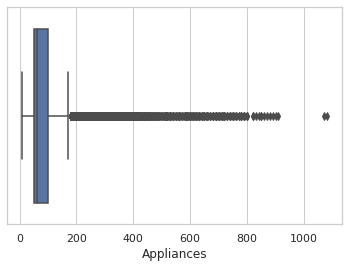

In [ ]:
# Find outliers

# boxplot appliances
sns.set(style="whitegrid")
ax = sns.boxplot(df.Appliances)

From above boxplots we can say that there are lot of outliers in our target features

In [ ]:
# Creating fuction for Removing the outliers
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]

In [ ]:
#Another method for Outliers removal

# df = df.dropna()
# df = df.drop(df[(df.Appliances>790)|(df.Appliances<0)].index)

In [ ]:
for i in df.columns:
      if i == df.columns[1]:
        removeOutliers(df, i) 
# Assigning filtered data back to our original variable
df = filtered_data
print("Shape of data after outlier removal is: ", df.shape)

IQR value for column Appliances is: 50.0
Shape of data after outlier removal is:  (17597, 28)


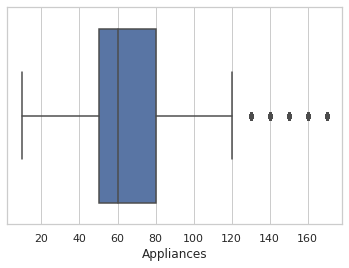

In [ ]:
sns.set(style="whitegrid")
ax = sns.boxplot(df.Appliances)

As we can see all Outliers are gone from our Dataset according to IQR method

Normality Checking of Taget Feature

In [ ]:
target_var_original = df[['Appliances']]
# Creating normality check function
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=plt)
    plt.show()

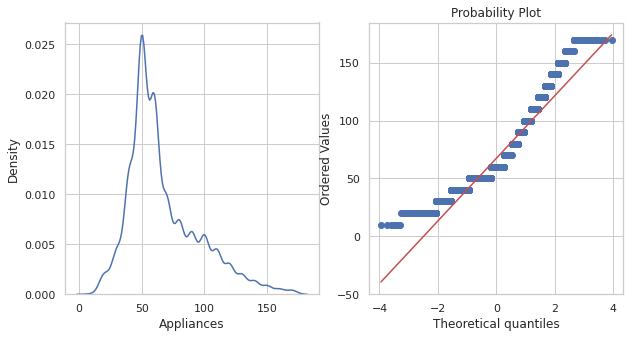

In [ ]:
#Normality checking via created function
normality(target_var_original,'Appliances')

In [ ]:
# Checking Skewness
target_var_original['Appliances'].skew()

1.0793897793506109

So our graph is movig towards to y axis as it is positively skewed and we couldn't get any better visualziation with these type of graph.
<br>So,It better to take Log or Square Root or Exponential of the dependent variable to draw the graph.

**Let's take a log of Appliances and draw the plot.....

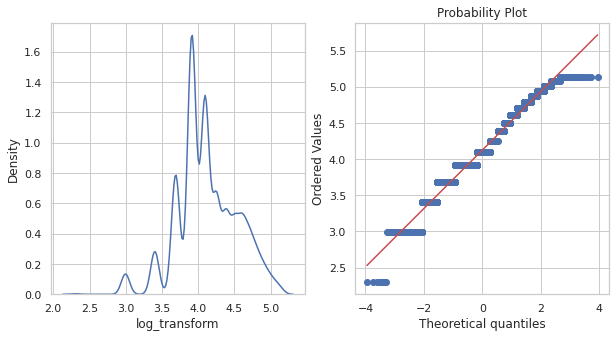

In [ ]:
# Logarithmic Transformation – This will convert the Price value to its log value i.e log(Appliances)
target_var_original['log_transform']=np.log(target_var_original['Appliances'])
normality(target_var_original,'log_transform')

In [ ]:
# Checking Skewness
target_var_original['log_transform'].skew()

-0.03727741267472712

**Let's take a Square Root of Appliances and draw the plot.....

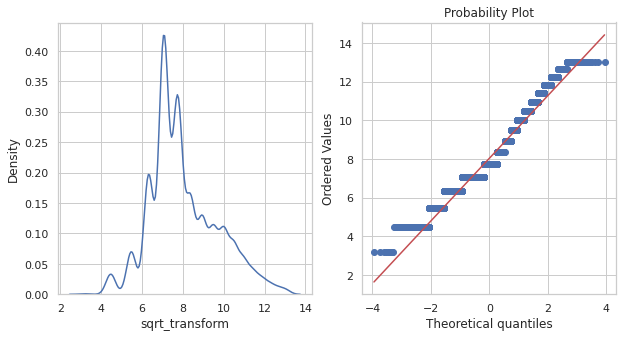

In [ ]:
# Square Root Transformation – This transformation will take the square root of the Price column i.e sqrt(Appliances).
target_var_original['sqrt_transform']=np.sqrt(df.Appliances)
normality(target_var_original,'sqrt_transform')

In [ ]:
# Checking Skewness
target_var_original['sqrt_transform'].skew()

0.5743520376079689

Observation:
We observe that none of the transformations are making our target variable perfectly normal, but still Square Root trasnformation is 
giving better results than others.

The Square root Transformation has kind of converted the feature to almost normal distributed. Most of the data points are also falling on the line in the Q-Q plot. This one is better than the log transformation for the Appliances feature. So we will be applying Square Root transformation on the target variable.

In [ ]:
#Applying sqare root to our target column
df['Appliances']=np.sqrt(df.Appliances)

Featching information from Date column

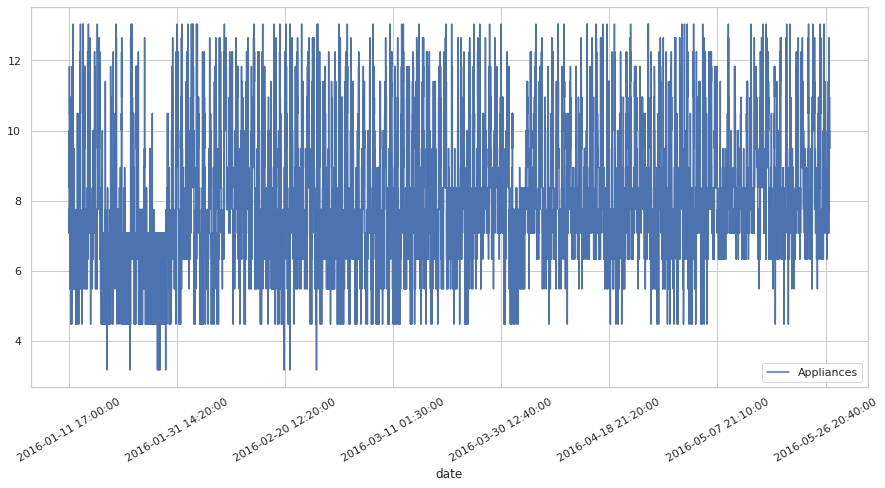

In [ ]:
# checking Data regarding date and time
df.plot(x='date', y='Appliances', figsize=(15,7), rot=30);


Observation-
The data contains date and time as well.This may be a case of time-series forecasting problem. **As of now, I am not proceeding with time-series approach.** I will be solving the problem using general ML techniques. But if given more time, i would give a chance to time-series also(AFTER TIME SERIES LECTURE COMPLETION) and would check how our data behaves on time-series models.

Even if we are not proceeding with time-series appraoch, we can extract useful information from the datetime feature.

In [ ]:
df['date']

0        2016-01-11 17:00:00
1        2016-01-11 17:10:00
2        2016-01-11 17:20:00
3        2016-01-11 17:30:00
4        2016-01-11 17:40:00
                ...         
19727    2016-05-27 16:50:00
19728    2016-05-27 17:00:00
19729    2016-05-27 17:10:00
19730    2016-05-27 17:20:00
19731    2016-05-27 17:30:00
Name: date, Length: 17597, dtype: object

The idea is that appliances' load is hour, day, week, month dependent. It is logical assumption that in night hours the load is low or at weekends the energy consumption is higher than the weekdays because more people are at home.

Additionaly, it is expected a correlation between temperature/humidity and energy load. For instance, when someone cooks(higher consumption) probably the temperature in the kichen raises.

Moreover, we can use qualitative predictors to indicate if a mesured load is lower or higher in comparison to the average energy load a given time interval.

I will append several columns as new features to the original data, based on the above-mentioned assumptions and then i will find out which of them explain better appliances consumption.

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# df['month'] = df.date.dt.month       
# df['weekday'] = df.date.dt.weekday   
# df['hour'] = df.date.dt.hour         
# df['week'] = df.date.dt.week         

In [ ]:
# Dropping 'date' column
df.drop(columns=['date'], inplace=True)

Date dropping reason: As we are not trying to analyze the problem as Time Series rather regress on "Appliance" column.



In [ ]:
temp_cols = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]
humidity_cols = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]
weather_cols = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"] 
random_cols = ["rv1", "rv2"]
date_time_cols = ['month', 'weekday', 'hour', 'week']
target = ["Appliances"]

Checking distribution of features:-

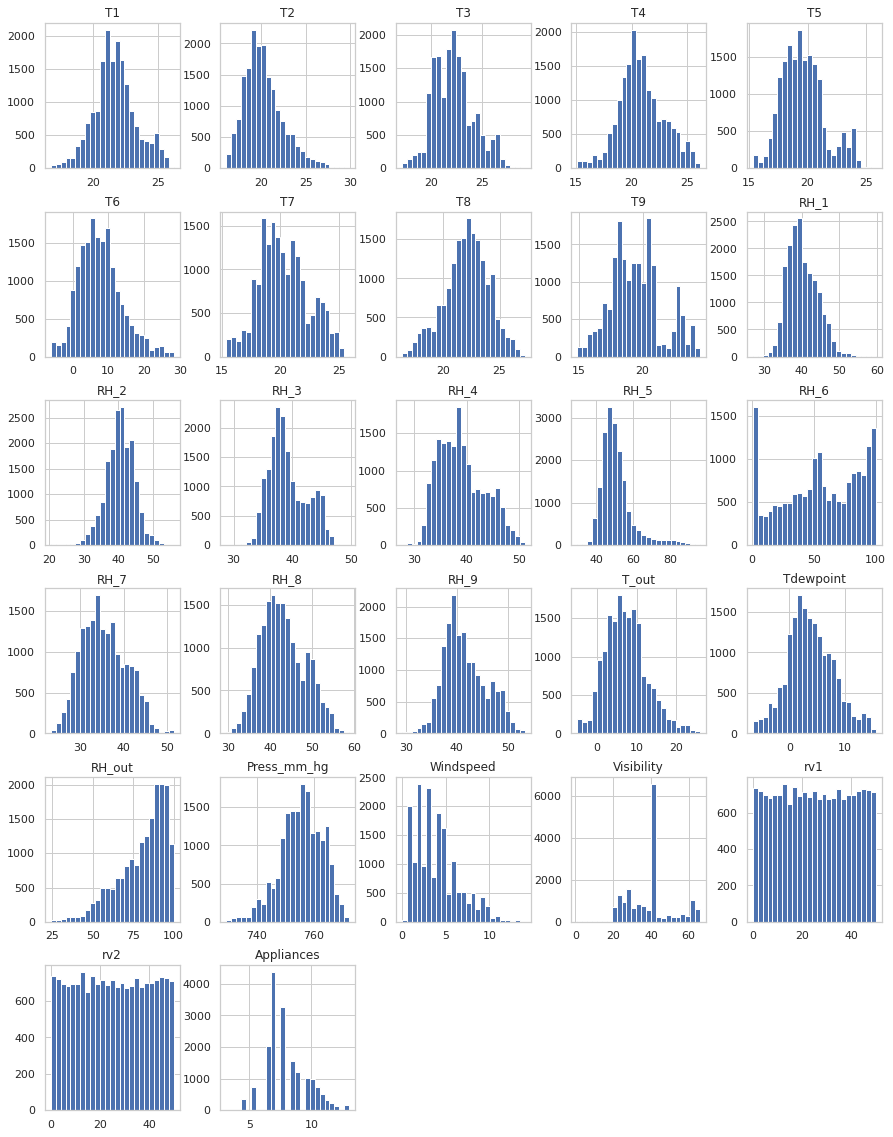

In [ ]:
df[temp_cols+ humidity_cols+ weather_cols + random_cols+ target].hist(bins=25, figsize=(15,20));

In [ ]:
df.skew()

Appliances     0.574352
T1             0.106392
RH_1           0.471071
T2             0.860361
RH_2          -0.302516
T3             0.413493
RH_3           0.481905
T4             0.151715
RH_4           0.455104
T5             0.550737
RH_5           1.838538
T6             0.587853
RH_6          -0.247152
T7             0.247172
RH_7           0.255466
T8            -0.273553
RH_8           0.330635
T9             0.369798
RH_9           0.380360
T_out          0.516237
Press_mm_hg   -0.414774
RH_out        -0.992142
Windspeed      0.910927
Visibility     0.417426
Tdewpoint      0.229723
rv1            0.001072
rv2            0.001072
dtype: float64

Positively skewed(>1):- Appliances, RH_5.

Moderately Positively skewed(0.5 to 1):- T2, T5, T6, T_out, RH_out, Windspeed.

Normal Distributed(-0.5 to +0.5):- T1, T3, T4, T7, T8, T9, RH_1, RH_2, RH_3, RH_4, RH_6, RH_7, RH_8, RH_9, Press_mm_hg, Visibility, Tdewpoint, rv1, rv2,

Negative skewed(-0.5 to -1):- No features.

Moderately Negtively skewed(>-1):- RH_out.



In [ ]:
df

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,7.745967,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.530000,6.600000,733.50,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,7.745967,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,...,17.066667,45.560000,6.483333,733.60,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,7.071068,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,...,17.000000,45.500000,6.366667,733.70,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,7.071068,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,...,17.000000,45.400000,6.250000,733.80,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,7.745967,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,...,17.000000,45.400000,6.133333,733.90,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19727,10.954451,25.500000,47.456667,26.000000,42.320000,27.663333,40.693333,24.700000,45.560000,23.200000,...,23.200000,46.718000,22.966667,755.25,55.000000,2.833333,22.166667,13.366667,1.796395,1.796395
19728,10.488088,25.600000,47.193333,25.968571,42.528571,27.390000,41.030000,24.700000,45.626667,23.200000,...,23.200000,46.751429,23.000000,755.20,55.000000,3.000000,22.000000,13.400000,18.248201,18.248201
19729,9.486833,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.700000,45.626667,23.200000,...,23.200000,46.745000,22.866667,755.20,55.333333,3.166667,22.833333,13.366667,16.966162,16.966162
19730,10.000000,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,...,23.200000,46.790000,22.733333,755.20,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812


Checking relationship or correlation

In [ ]:
# Heatmap without log transformation on target variable is not that good
# fig = plt.figure(figsize=(20,20))
# sns.heatmap(df.corr(), annot=True, square=True);

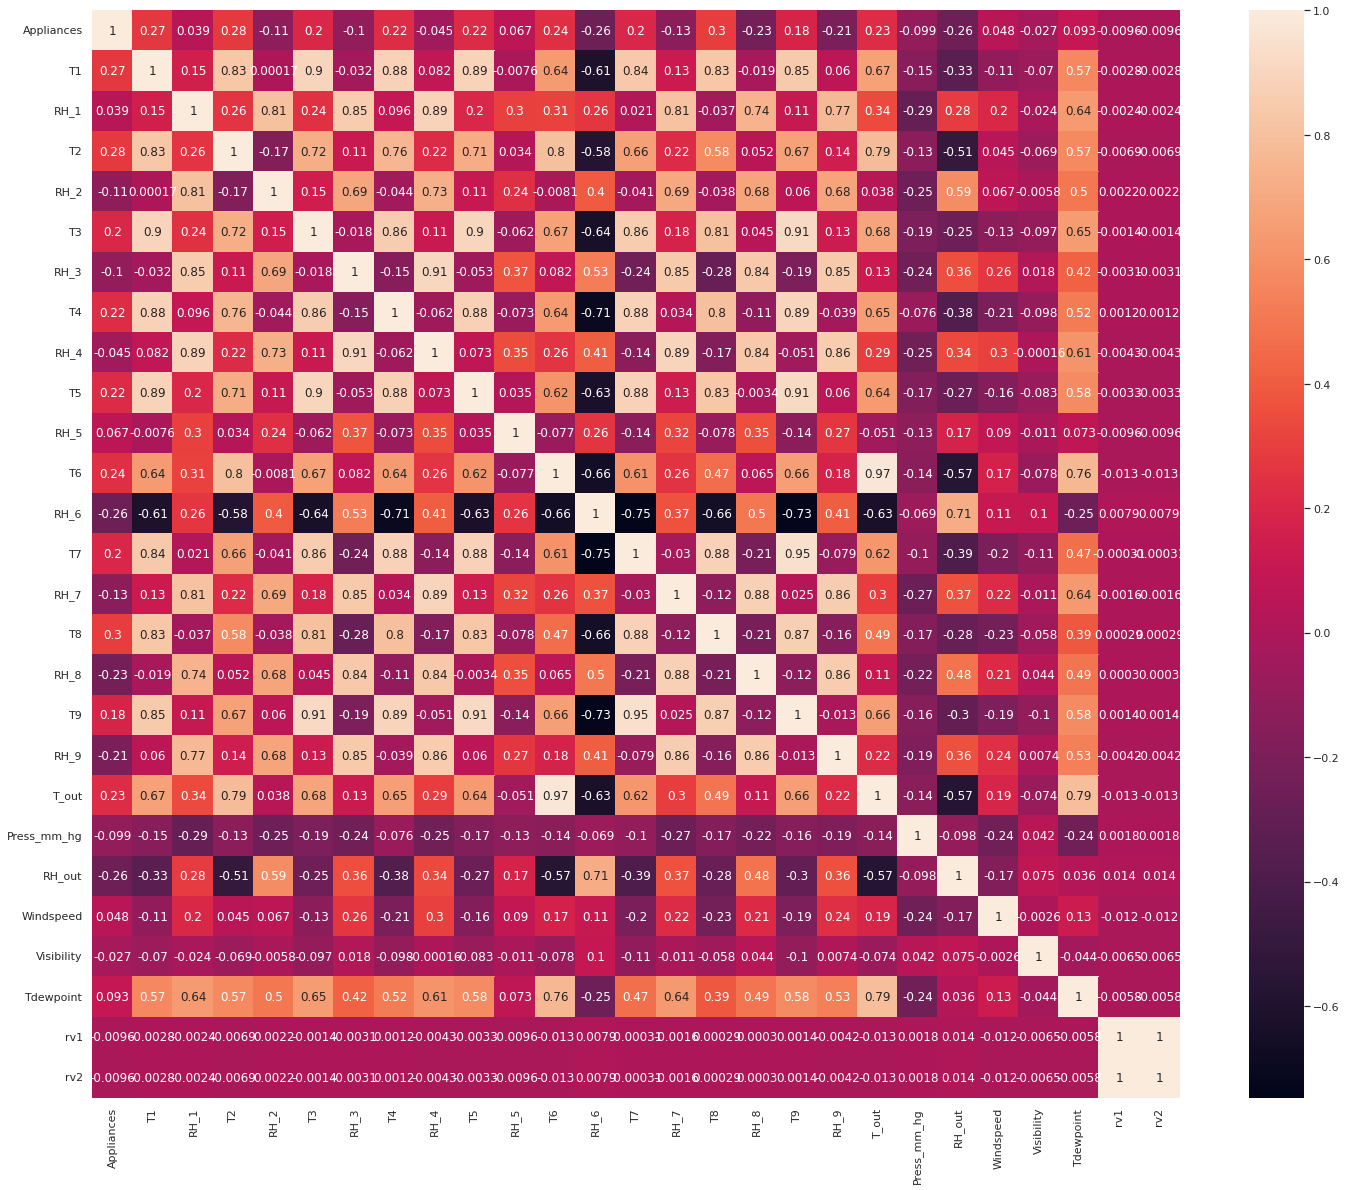

In [ ]:
# Heatmap is good with log transformation on target variable in this scenario

fig = plt.figure(figsize=(25,20))
sns.heatmap(df.corr(), annot=True, square=True);


Observation:¶
From the above two heatmaps, we observe that after log trasnformation, our target variable is having better relationship with other variables. That's a good thing for us.

# Observations based on correlation plot:-
1. Temperature - All the temperature variables from T1-T9 and T_out have positive correlation with the target Appliances . 

2. For the indoor temperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. 

3. Five columns have a high degree of correlation with T9 - T3,T4,T5,T7,T8 also T6 & T_Out has high correlation(both temperatures from outside) . Hence T6 & T9 can be removed from training set as information provided by them can be provided by other fields.

4. Weather attributes - Visibility, Tdewpoint, Press_mm_hg have low correlation values

5. Humidity - RH_3 & RH_4 has high correlation(both temperatures from outside) . Hence RH_3 & RH_4 can be removed from training set as information provided by them can be provided by other fields.
There are no significantly high correlation cases (> 0.9) for humidity sensors.

6. Random variables have no role to play

In [ ]:
# #Remove unneccessary column
df.drop(["rv1","rv2","T6","T9",'RH_3'],axis=1 , inplace=True)
# we can do it in Feature Selection 


In [ ]:
# Functions to be used from the plots

def daily(x,df=df):
    return df.groupby('weekday')[x].mean()

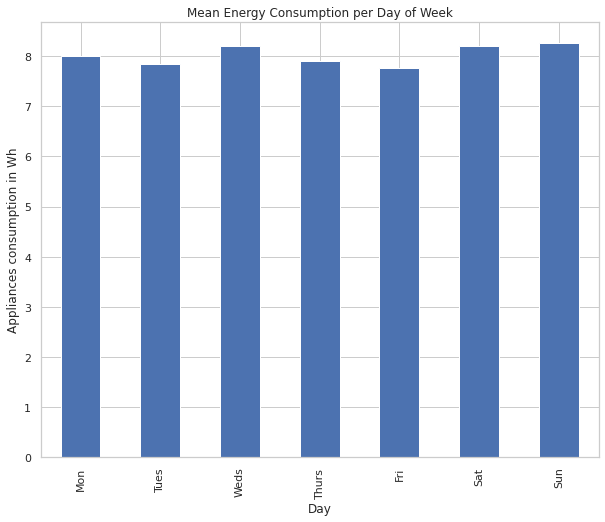

In [ ]:
# Plot of Mean Energy Consumption per Day of Week

daily('Appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

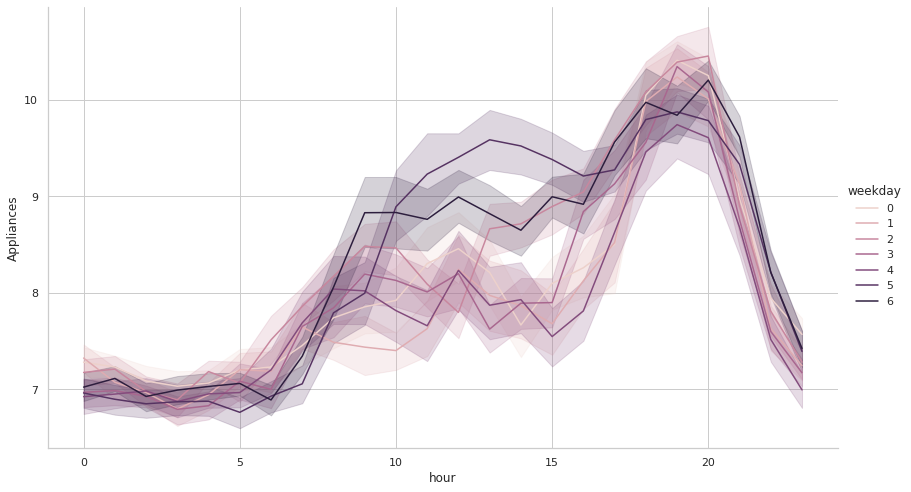

In [ ]:
sns.relplot(y='Appliances', x='hour', data=df, kind='line', hue='weekday', height=7, aspect=1.7)
plt.show()

We see that everyday, the usage is maximum around 15 hours. But on 5th and 6th day, it is even higher during the same hours.



# Features Seletion 

In [ ]:
corr_tran_df =df.corr()
corr_tran_df

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
Appliances,1.000000,0.272915,0.039024,0.282650,-0.114088,0.204852,-0.101259,0.222268,-0.045263,0.216903,...,0.181491,-0.206174,0.227945,-0.098959,-0.260228,0.048212,-0.026753,0.093418,-0.009593,-0.009593
T1,0.272915,1.000000,0.153799,0.831967,0.000171,0.897053,-0.032224,0.881085,0.081965,0.887043,...,0.847975,0.060026,0.670593,-0.152247,-0.332730,-0.107067,-0.070405,0.565168,-0.002757,-0.002757
RH_1,0.039024,0.153799,1.000000,0.256932,0.806895,0.243415,0.854656,0.096399,0.890015,0.196578,...,0.111263,0.770466,0.339477,-0.288807,0.284023,0.203744,-0.023531,0.642200,-0.002381,-0.002381
T2,0.282650,0.831967,0.256932,1.000000,-0.169432,0.724341,0.114784,0.758124,0.218405,0.713467,...,0.670428,0.143615,0.787394,-0.133023,-0.508107,0.044776,-0.069210,0.573864,-0.006851,-0.006851
RH_2,-0.114088,0.000171,0.806895,-0.169432,1.000000,0.151695,0.689152,-0.044259,0.727150,0.110604,...,0.060387,0.680480,0.038352,-0.251208,0.588761,0.067110,-0.005777,0.504801,0.002199,0.002199
T3,0.204852,0.897053,0.243415,0.724341,0.151695,1.000000,-0.018452,0.862704,0.113369,0.899945,...,0.912793,0.130937,0.684701,-0.192824,-0.251120,-0.128159,-0.097455,0.648264,-0.001382,-0.001382
RH_3,-0.101259,-0.032224,0.854656,0.114784,0.689152,-0.018452,1.000000,-0.148553,0.910038,-0.053136,...,-0.190658,0.845196,0.125947,-0.237246,0.357759,0.263632,0.017537,0.421794,-0.003149,-0.003149
T4,0.222268,0.881085,0.096399,0.758124,-0.044259,0.862704,-0.148553,1.000000,-0.062208,0.877143,...,0.892299,-0.039221,0.654619,-0.076398,-0.378222,-0.205010,-0.097992,0.516391,0.001220,0.001220
RH_4,-0.045263,0.081965,0.890015,0.218405,0.727150,0.113369,0.910038,-0.062208,1.000000,0.073212,...,-0.050797,0.855029,0.292575,-0.246577,0.335375,0.301535,-0.000155,0.611988,-0.004286,-0.004286
T5,0.216903,0.887043,0.196578,0.713467,0.110604,0.899945,-0.053136,0.877143,0.073212,1.000000,...,0.913660,0.059772,0.639284,-0.170841,-0.266433,-0.162083,-0.082764,0.578821,-0.003278,-0.003278


In [ ]:
corr_appliances = corr_tran_df[['Appliances']]
corr_appliances

,Appliances
Appliances,1.000000
T1,0.272915
RH_1,0.039024
T2,0.282650
RH_2,-0.114088
T3,0.204852
RH_3,-0.101259
T4,0.222268
RH_4,-0.045263
T5,0.216903


In [ ]:
corr_appliances.sort_values('Appliances', inplace=True)


In [ ]:
corr_appliances

,Appliances
RH_out,-0.260228
RH_6,-0.259873
RH_8,-0.227204
RH_9,-0.206174
RH_7,-0.133312
RH_2,-0.114088
RH_3,-0.101259
Press_mm_hg,-0.098959
RH_4,-0.045263
Visibility,-0.026753


In [ ]:
~corr_appliances['Appliances'].between(-0.09, 0.09)

RH_out          True
RH_6            True
RH_8            True
RH_9            True
RH_7            True
RH_2            True
RH_3            True
Press_mm_hg     True
RH_4           False
Visibility     False
rv1            False
rv2            False
RH_1           False
Windspeed      False
RH_5           False
Tdewpoint       True
T9              True
T7              True
T3              True
T5              True
T4              True
T_out           True
T6              True
T1              True
T2              True
T8              True
Appliances      True
Name: Appliances, dtype: bool

In [ ]:
#remove those features which are not correlated upto 10% to our target column('Appliances')
imp_features= corr_appliances.loc[~corr_appliances['Appliances'].between(-0.09, 0.09)]

In [ ]:
imp_features

,Appliances
RH_out,-0.260228
RH_6,-0.259873
RH_8,-0.227204
RH_9,-0.206174
RH_7,-0.133312
RH_2,-0.114088
RH_3,-0.101259
Press_mm_hg,-0.098959
Tdewpoint,0.093418
T9,0.181491


In [ ]:
imp_features_list = imp_features.index.tolist()
imp_features_list

['RH_out',
 'RH_6',
 'RH_8',
 'RH_9',
 'RH_7',
 'RH_2',
 'RH_3',
 'Press_mm_hg',
 'Tdewpoint',
 'T9',
 'T7',
 'T3',
 'T5',
 'T4',
 'T_out',
 'T6',
 'T1',
 'T2',
 'T8',
 'Appliances']

In [ ]:
imp_df = df[imp_features_list]



In [ ]:
imp_df.columns

Index(['RH_out', 'RH_6', 'RH_8', 'RH_9', 'RH_7', 'RH_2', 'RH_3', 'Press_mm_hg',
       'Tdewpoint', 'T9', 'T7', 'T3', 'T5', 'T4', 'T_out', 'T6', 'T1', 'T2',
       'T8', 'Appliances'],
      dtype='object')

In [ ]:
imp_df.shape


(17597, 20)

In [ ]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

max: 13.038404810405298
min: 3.1622776601683795


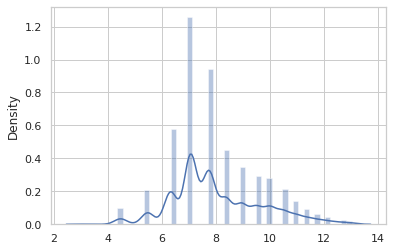

In [ ]:
print('max:',df['Appliances'].max())
print('min:',df['Appliances'].min())

sns.distplot(np.array(df['Appliances']))

In [ ]:
df=df.drop(['month','hour','weekday','week'],axis=1)

In [ ]:
df=df.drop(['rv1','rv2'],axis=1)

In [ ]:
df=df.drop(['T1'],axis=1)

In [ ]:
df=df.drop(['T9'],axis=1)

In [ ]:
df=df.drop(['Press_mm_hg'],axis=1)

In [ ]:
df=df.drop(['RH_2'],axis=1)

In [ ]:
df=df.drop(['RH_3'],axis=1)

In [ ]:
df=df.drop(['T7'],axis=1)

69.82

In [ ]:
df=df.drop(['RH_4'],axis=1)

69.57

In [ ]:
# df=df.drop(['T3'],axis=1)

69.47

In [ ]:
# df=df.drop(['T5'],axis=1)

69.41

In [ ]:
# df=df.drop(['T4'],axis=1)

69.11

In [ ]:
# df=df.drop(['RH_9'],axis=1)

In [ ]:
# df=df.drop(['RH_8'],axis=1)

69.26

In [ ]:
# df=df.drop(['T8'],axis=1)

67.84

In [ ]:
# df=df.drop(['RH_1'],axis=1)

66.50

In [ ]:
# df=df.drop(['T2'],axis=1)

65.62

In [ ]:
# df=df.drop(['RH_7'],axis=1)

64.41

In [ ]:
# df=df.drop(['T_out'],axis=1)

63.83

In [ ]:
# df=df.drop(['RH_out'],axis=1)

62.64

In [ ]:
# df=df.drop(['RH_5'],axis=1)

58.36

In [ ]:
# df=df.drop(['T6'],axis=1)

In [ ]:
# df=df.drop(['Visibility'],axis=1)

In [ ]:
df.columns

Index(['Appliances', 'RH_1', 'T2', 'T3', 'T4', 'T5', 'RH_5', 'T6', 'RH_6',
       'RH_7', 'T8', 'RH_8', 'RH_9', 'T_out', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint'],
      dtype='object')

In [ ]:
calc_vif(df[[i for i in df.describe().columns if i not in ['Appliances']]])

,variables,VIF
0,RH_1,355.758422
1,T2,452.579451
2,T3,1115.700965
3,T4,713.532172
4,T5,944.895938
5,RH_5,43.749822
6,T6,74.562810
7,RH_6,35.689269
8,RH_7,386.898957
9,T8,595.559280


In [ ]:
app=df[['Appliances']]

In [ ]:
# df=df[['Windspeed','Visibility']]
dff=df.drop(['Appliances'],axis=1)

In [ ]:
imp_df.columns

Index(['RH_out', 'RH_6', 'RH_8', 'RH_9', 'RH_7', 'RH_2', 'RH_3', 'Press_mm_hg',
       'Tdewpoint', 'T9', 'T7', 'T3', 'T5', 'T4', 'T_out', 'T6', 'T1', 'T2',
       'T8', 'Appliances'],
      dtype='object')

Processing the data before feeding it to ML models.¶


In [ ]:
# X = imp_df.drop(columns=['Appliances'])
# y = imp_df[['Appliances']]

In [ ]:
X=dff
y=app

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Scale the data
scaler = StandardScaler() 
X_train_sc=scaler.fit_transform(X_train)
X_test_sc=scaler.transform(X_test)
y_train_sc=scaler.fit_transform(y_train)
y_test_sc=scaler.transform(y_test)

APPLYING PCA BUT IT IS NOT GIVING GOOD RESULTS

In [ ]:
# Applying PCA
# pca = PCA(n_components = 0.99)
# X_train_sc = pca.fit_transform(X_train_sc)
# X_test_sc = pca.transform(X_test_sc)

In [ ]:
# pca.components_

In [ ]:
# pca.explained_variance_

# Making Models

In [ ]:
models = [
           ['LinearRegression: ', LinearRegression()],
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['DecisionTreeRegresson: ', DecisionTreeRegressor()],
           ['RandomForest ',RandomForestRegressor()],
           ['GradientBoostingRegression: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()],
           ['AdaBoostRegressor: ',AdaBoostRegressor()],
           ['LgbmRegressor: ',lgbm.LGBMRegressor()]
         ]

In [ ]:
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train_sc,y_train_sc)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train_sc,curr_model.predict(X_train_sc))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test_sc,curr_model.predict(X_test_sc))
    # curr_model_data["Test_MSE_Score"] = mean_squared_error(y_test_sc,curr_model.predict(X_test_sc))
    curr_model_data["Test_RMSE_Score"] = sqrt(mean_squared_error(y_test_sc,curr_model.predict(X_test_sc)))
    model_data.append(curr_model_data)


[17:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model_data

[{'Name': 'LinearRegression: ',
  'Test_R2_Score': 0.31197390673099634,
  'Test_RMSE_Score': 0.8439805905039257,
  'Train_R2_Score': 0.2849355779870191,
  'Train_Time': 0.017290353775024414},
 {'Name': 'Lasso: ',
  'Test_R2_Score': -5.572927443520115e-06,
  'Test_RMSE_Score': 1.0174924951409106,
  'Train_R2_Score': 0.0,
  'Train_Time': 0.005289316177368164},
 {'Name': 'Ridge: ',
  'Test_R2_Score': 0.31197051571580914,
  'Test_RMSE_Score': 0.843982670328733,
  'Train_R2_Score': 0.2849352406452881,
  'Train_Time': 0.0035581588745117188},
 {'Name': 'DecisionTreeRegresson: ',
  'Test_R2_Score': 0.4910632642861291,
  'Test_RMSE_Score': 0.7258751093284725,
  'Train_R2_Score': 1.0,
  'Train_Time': 0.35962986946105957},
 {'Name': 'RandomForest ',
  'Test_R2_Score': 0.7167130262686261,
  'Test_RMSE_Score': 0.5415559191359137,
  'Train_R2_Score': 0.958436728970473,
  'Train_Time': 19.66942310333252},
 {'Name': 'GradientBoostingRegression: ',
  'Test_R2_Score': 0.4328522492531979,
  'Test_RMSE_Sc

In [ ]:

result= pd.DataFrame(model_data)


In [ ]:
result

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,LinearRegression:,0.017290,0.284936,0.311974,0.843981
1,Lasso:,0.005289,0.000000,-0.000006,1.017492
2,Ridge:,0.003558,0.284935,0.311971,0.843983
3,DecisionTreeRegresson:,0.359630,1.000000,0.491063,0.725875
4,RandomForest,19.669423,0.958437,0.716713,0.541556
5,GradientBoostingRegression:,5.664853,0.450213,0.432852,0.766263
6,XGBRegressor:,1.240275,0.449323,0.432326,0.766619
7,AdaBoostRegressor:,1.824798,0.147084,0.161090,0.931940
8,LgbmRegressor:,0.553251,0.688618,0.608508,0.636636


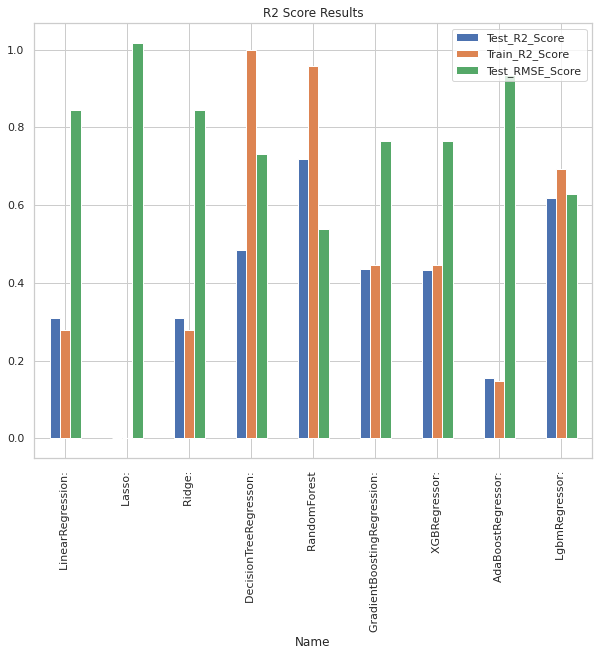

In [ ]:
result.plot(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' , 'Test_RMSE_Score'], kind="bar" , title = 'R2 Score Results' , figsize= (10,8)) 

Observation:
The model which has minimum rmse and maximum r2 is performing the best. Hence, Random Forest is performing the best.

test r2: 0.711

test RMSE: 0.516


	

# Hyper parameter tuning

In [ ]:
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = RandomForestRegressor(random_state=40)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(X_train_sc, y_train_sc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=40), n_jobs=-1,
             param_grid=[{'max_depth': [80, 150, 200, 250],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 150, 200, 250]}],
             scoring='r2', verbose=2)

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=80, max_features='sqrt', n_estimators=200,
                      random_state=40)

In [ ]:
# R2 score on training set with tuned parameters

grid_search.best_estimator_.score(X_train_sc,y_train_sc)

0.960146009813666

In [ ]:
# R2 score on test set with tuned parameters
grid_search.best_estimator_.score(X_test_sc,y_test_sc)


0.7254521256512858

In [ ]:
# RMSE score on test set with tuned parameters

np.sqrt(mean_squared_error(y_test_sc, grid_search.best_estimator_.predict(X_test_sc)))

0.5331372742813729

Observation:
With hyperparameter tuning the r2 has increased to 0.725 and RMSE is decreased to 0.533 which is good

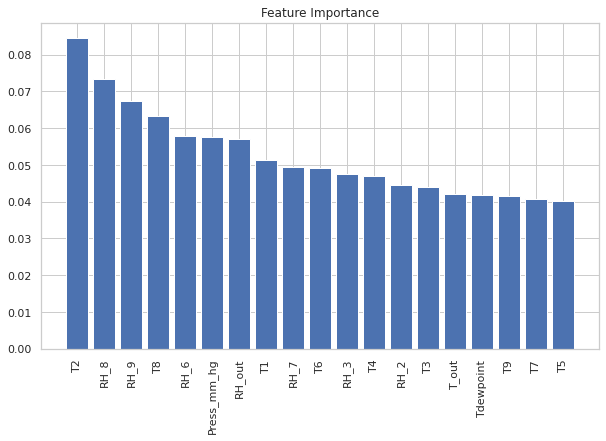

In [ ]:
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(10,6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

Now lets check for Bayes search 

In [ ]:
reg = RandomForestRegressor(random_state=40)
# Instantiate the bayes search model
bayes_search = BayesSearchCV(estimator=reg,
                       search_spaces = {
                          'max_depth': Integer(4,8),
                          'min_samples_leaf': Integer(10,100),
                          'min_samples_split': Integer(50,150),
                          'n_estimators': Integer(10,100)
                        },
                       cv = 5, verbose=2, scoring='r2')

bayes_search.fit(X_train_sc, y_train_sc)

In [ ]:
bayes_search.best_params_

In [ ]:
# R2 score on training set with tuned parameters

bayes_search.best_estimator_.score(X_train_sc,y_train_sc)

In [ ]:
# R2 score on test set with tuned parameters
bayes_search.best_estimator_.score(X_test_sc,y_test_sc)


In [ ]:
# RMSE score on test set with tuned parameters

np.sqrt(mean_squared_error(y_test_sc, bayes_search.best_estimator_.predict(X_test_sc)))

Observation:
With hyperparameter tuning the r2 has decreased to 0.420 and RMSE is increased to 0.731 which is not good.

Improvemente points:
Definitely, we have a scope of improvement here, specially in the feature engineering. Many of the features have outliers and are skewed. We can do some more EDA and FE to extract better features which can have better relationships with the target variable. Below are some more transformation which we can do to data.

To handle skeweness data:
We can apply some transformation like log, exp, boxcox, reciprocal on skewed features.
We can do discretisation on on some highly skewed data and check how it is performing.
To handle outliers:
Trimg the outliers. (chances of data loss)
Treat outliers as missing data and do imputation on them
Discretization
Model interpretation:
We can also use shap value to interprete the predictions.

# Explainability



SHAP: Shapley Additive Explanations**

In [ ]:
pip install shap

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import shap 
import graphviz

In [ ]:
X_train1=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
Y_train1=pd.DataFrame(y_train)
Y_test=pd.DataFrame(y_test)

In [ ]:
# Random Forest Regression
regressor_dtc = RandomForestRegressor()
regressor_dtc.fit(X_train, y_train)

In [ ]:
# define a tree explainer for the built model that can calculate shap values
explainer = shap.TreeExplainer(regressor_dtc)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.dependence_plot(5, shap_values, X_train)


In [ ]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(regressor_dtc)
# obtain shap values for the first row of the test data
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0])

Explainability Conclusion